In [102]:
import numpy as np
import torch
import torch.nn as nn 
import torch.optim as optim
import random
import pandas as pd
import matplotlib.pyplot as plt

Data Generator

In [103]:
matrix_a = np.array([[1, 1], [0, 1]])
matrix_b = np.array([[1, -1], [0, 1]])
matrix_c = np.array([[1, 0], [-1, 1]])
matrix_d = np.array([[1, 0], [1, 1]])

inverse_a = np.array([[1, -1], [0, 1]])
inverse_b = np.array([[1, 1], [0, 1]])
inverse_c = np.array([[1, 0], [1, 1]])
inverse_d = np.array([[1, 0], [-1, 1]])

def data_generator(num_points):
    data = []
    max_moves = 30
    end_position = np.array([[random.randint(1, 11),0]]) 
    last_move = 5
    for i in range(num_points):
        current_position = end_position
        moves = random.randint(1, max_moves)
        for q in range(moves):
            coin = random.randint(0,3)
            if coin == 0 and last_move != 1: 
                current_position = current_position @ inverse_a
                last_move = 0 
            if coin == 1 and last_move != 0: 
                current_position = current_position @ inverse_b
                last_move = 1 
            if coin == 2 and last_move != 3: 
                current_position = current_position @ inverse_c
                last_move = 2 
            if coin == 3 and last_move != 2: 
                current_position = current_position @ inverse_d
                last_move = 3 
        last_move_array = np.array([0,0,0,0])
        if last_move == 0: 
            last_move_array = np.array([1, 0, 0, 0 ])
        if last_move == 1: 
            last_move_array = np.array([0, 1, 0, 0 ])
        if last_move == 2: 
            last_move_array = np.array([0, 0, 1, 0 ])
        if last_move == 3: 
            last_move_array = np.array([0, 0, 0, 1])
        current_position = np.append(current_position, last_move_array)
        data.append(current_position.tolist())
    return data

Turn to CSV using Pandas

In [104]:
data_pd = pd.DataFrame(data_generator(20000))
data_pd.to_csv("generated_pairs.csv", index = False)

Turn CSV file to tensor

In [105]:
data = pd.read_csv("generated_pairs.csv", names=["0","1","2", "3", "4", "5"], delimiter=",")
dataset = torch.utils.data.TensorDataset(
    torch.tensor(data.loc[:, "0":"1"].values,dtype=torch.float32), # input 
    torch.tensor(data.loc[:, "2":"5"].values, dtype = torch.float32) #output 
)
X, Y = dataset[:] #label input and output 

Make the Model

In [106]:
X

tensor([[ 0.0000e+00,  1.0000e+00],
        [ 2.4800e+02, -8.8800e+02],
        [-2.4000e+01,  5.6000e+01],
        ...,
        [ 8.0000e+00, -8.0000e+00],
        [ 8.0800e+02,  1.8400e+03],
        [ 1.4720e+03, -6.4560e+03]])

In [107]:
#https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step 
model = nn.Sequential(
    nn.Linear(2, 128), #first layer 128
    nn.ReLU(),
    nn.Linear(128,64), #second layer 64
    nn.ReLU(),
    nn.Linear(64, 16), #third layer 16
    nn.ReLU(),
    nn.Linear(16,4), #singular output 
    nn.Sigmoid()
)

for name, param in model.named_parameters():
    print(f"Layer: {name}, Data Type: {param.dtype}")

loss_function = nn.MSELoss() #should this be our loss function too? 
optimizer = optim.SGD(model.parameters(), lr = 0.02) #chose Adam and lr from site 

Layer: 0.weight, Data Type: torch.float32
Layer: 0.bias, Data Type: torch.float32
Layer: 2.weight, Data Type: torch.float32
Layer: 2.bias, Data Type: torch.float32
Layer: 4.weight, Data Type: torch.float32
Layer: 4.bias, Data Type: torch.float32
Layer: 6.weight, Data Type: torch.float32
Layer: 6.bias, Data Type: torch.float32


Training Model

In [108]:
num_epochs = 200
num_batches = 10 

In [109]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()
        X_batch = X[i:i+num_batches]
        # print(X_batch)
        y_pred = model(torch.Tensor(X_batch))
        Y_batch = Y[i:i+num_batches]
        loss = loss_function(y_pred, torch.Tensor(Y_batch))
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print(f'Finished epoch {epoch}, latest loss {total_loss / len(data)}')

Finished epoch 0, latest loss 0.00019662582029742506
Finished epoch 1, latest loss 0.0001778434225394901
Finished epoch 2, latest loss 0.00016965948517969458
Finished epoch 3, latest loss 0.00015769639773211726
Finished epoch 4, latest loss 0.00014655413994055547
Finished epoch 5, latest loss 0.00014044199555905175
Finished epoch 6, latest loss 0.00012653667685938002
Finished epoch 7, latest loss 0.00012603963436433587
Finished epoch 8, latest loss 0.00012479903577154955
Finished epoch 9, latest loss 0.00012447280829491945
Finished epoch 10, latest loss 0.00012329657465736543
Finished epoch 11, latest loss 0.0001231449077912649
Finished epoch 12, latest loss 0.00012209445936942921
Finished epoch 13, latest loss 0.00012187321351996708
Finished epoch 14, latest loss 0.0001208202946091299
Finished epoch 15, latest loss 0.00012107928544782077
Finished epoch 16, latest loss 0.0001197853362874373
Finished epoch 17, latest loss 0.00011978415058682033
Finished epoch 18, latest loss 0.000118693

In [142]:
def euclidean_algorithm(pair): 
    a = pair[0]
    b = pair[1]
    plt.plot(a.detach(), b.detach(), "ro", markersize = 3)
    index = 1
    old_matrix = np.array([[1, 1], [1, 1]])

    
    while index < 500: 
        
        index += 1
        if a==0 or b==0: 
            return
        pred = float(torch.argmax(model(torch.tensor([[a,b]]))))
        print(index , ",",  pred)
        if pred == 0: # if first index has biggest value 
            if not np.array_equal(old_matrix , matrix_b):
                pair = pair @ matrix_a
                old_matrix = matrix_a
        if pred == 1: # if second index has biggest value
            if not np.array_equal(old_matrix , matrix_a):
                pair = pair @ matrix_b
                old_matrix = matrix_b
        if pred == 2: # if third index has biggest value
            if not np.array_equal(old_matrix , matrix_d):
                pair = pair @ matrix_c
                old_matrix = matrix_c
        if pred == 3: # if fourth index has biggest value
            if not np.array_equal(old_matrix ,matrix_c):
                pair = pair @ matrix_d
                old_matrix = matrix_d
        print(pair)
        a = float(pair[0])
        b = float(pair[1])
        plt.plot(a, b, "ro", markersize = 3) #from cs544 notes 

2 , 0.0
tensor([-5., 15.], dtype=torch.float64)
3 , 0.0
tensor([-5., 10.], dtype=torch.float64)
4 , 3.0
tensor([ 5., 10.], dtype=torch.float64)
5 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
6 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
7 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
8 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
9 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
10 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
11 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
12 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
13 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
14 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
15 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
16 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
17 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
18 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
19 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
20 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
21 , 2.0
tensor([ 5., 10.], dtype=torch.float64)
22 , 2.0
tensor([ 5., 10.], 

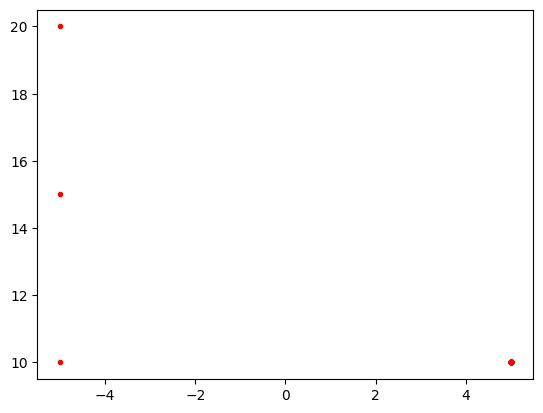

In [144]:
pair = torch.tensor([-5,20], dtype=torch.float32)
print(euclidean_algorithm(pair))
print(model(pair))
print(float(torch.argmax(model(pair))))